# Running MAGICC in Parallel

The code in this notebook is a work in progress so it is quite verbose. In future prettier wrappers can be written but for now it's helpful to have things in one place.

In [1]:
import glob
import logging
import multiprocessing
import os.path
from concurrent.futures import ProcessPoolExecutor
from subprocess import CalledProcessError

import f90nml
import matplotlib.pyplot as plt
import numpy as np
from openscm_runner.adapters.magicc7._parallel_process import _parallel_process
from scmdata import df_append

from _magicc_instances import _MagiccInstances

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler
/opt/tljh/user/lib/python3.7/site-packages/openscm_runner/run.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
File doesn't exist 


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

stderr_info_handler = logging.StreamHandler()
formatter = logging.Formatter("%(name)s - %(levelname)s: %(message)s")
stderr_info_handler.setFormatter(formatter)
logger.addHandler(stderr_info_handler)

## Config

In [3]:
# how many MAGICC workers to use
NWORKERS = 4

In [4]:
# where should MAGICC copies be made
MAGICC_ROOT_DIR = os.path.expanduser(os.path.join("~", "magicc-workers"))
MAGICC_ROOT_DIR

'/home/jupyter-znicholls/magicc-workers'

In [5]:
# where is the MAGICC executable to copy
os.environ["MAGICC_EXECUTABLE_6"] = os.path.expanduser(os.path.join(
    "~", "pymagicc", "pymagicc", "MAGICC6", "run", "magicc6.exe"
))

## Parallel setup

In [6]:
shared_manager = multiprocessing.Manager()
shared_dict = shared_manager.dict()

In [7]:
if not os.path.isdir(MAGICC_ROOT_DIR):
    os.makedirs(MAGICC_ROOT_DIR)

In [8]:
def _setup_func(magicc):
    logger.info(
        "Setting up MAGICC worker in %s", magicc.root_dir,
    )

    magicc.set_config(
        # can set config to be used in all runs here e.g.
        # out_forcing=1
    )

In [9]:
def init_magicc_worker(dict_shared_instances, root_dir):
    logger.debug("Initialising process %s", multiprocessing.current_process())
    logger.debug("Existing instances %s", dict_shared_instances)

In [10]:
def _run_func(magicc, cfg):
    try:
        scenario = cfg.pop("scenario")
        res = magicc.run(**cfg)
        res.set_meta(cfg["run_id"], "run_id")
        res.set_meta(scenario, "scenario")
        
        return res
    except CalledProcessError as e:
        # Swallow the exception, but return None
        logger.debug("magicc run failed: {} (cfg: {})".format(e.stderr, cfg))
        return None

In [11]:
instances = _MagiccInstances(existing_instances=shared_dict)

In [12]:
def _execute_run(cfg, run_func, setup_func):
    magicc = instances.get(root_dir=MAGICC_ROOT_DIR, init_callback=setup_func)

    return run_func(magicc, cfg)

In [13]:
def make_runs_list(cfgs):
    """
    Turn the configs into a list which can be run in parallel.
    
    Assigns ``run_id`` for each run if it's not already there.
    """
    out = [
        {
            "cfg": {**{"run_id": i}, **cfg},
            "run_func": _run_func,
            "setup_func": _setup_func,
        }
        for i, cfg in enumerate(cfgs)
    ]
    if not all(["scenario" in c["cfg"] for c in out]):
        raise KeyError("Please include a key 'scenario' in each config")
        
    return out

## Runs

First we need to get all our configs as a list of dictionaries, like the below.

In [14]:
# one could also load the configs from the probabilistic sets
# using f90nml by doing something like
#
# cfgs = []
# for f in probabilistic_files:
#     cfgs.append(f90nml.read(f)["nml_allcfgs"])

cfgs = [
    {
        "core_climatesensitivity": cs,
        "rf_cloud_albedo_aer_wm2": rfcloud,
        "file_emissionscenario": scen,
        "scenario": scen.replace(".SCEN", "")
    }
    for cs, rfcloud in zip(
        np.round(np.linspace(2, 6, 50), 2), 
        np.round(np.linspace(-0.2, -1.5, 50), 2)
    )
    for scen in ["RCP26.SCEN", "RCP45.SCEN"]
]
cfgs[:10]

[{'core_climatesensitivity': 2.0,
  'rf_cloud_albedo_aer_wm2': -0.2,
  'file_emissionscenario': 'RCP26.SCEN',
  'scenario': 'RCP26'},
 {'core_climatesensitivity': 2.0,
  'rf_cloud_albedo_aer_wm2': -0.2,
  'file_emissionscenario': 'RCP45.SCEN',
  'scenario': 'RCP45'},
 {'core_climatesensitivity': 2.08,
  'rf_cloud_albedo_aer_wm2': -0.23,
  'file_emissionscenario': 'RCP26.SCEN',
  'scenario': 'RCP26'},
 {'core_climatesensitivity': 2.08,
  'rf_cloud_albedo_aer_wm2': -0.23,
  'file_emissionscenario': 'RCP45.SCEN',
  'scenario': 'RCP45'},
 {'core_climatesensitivity': 2.16,
  'rf_cloud_albedo_aer_wm2': -0.25,
  'file_emissionscenario': 'RCP26.SCEN',
  'scenario': 'RCP26'},
 {'core_climatesensitivity': 2.16,
  'rf_cloud_albedo_aer_wm2': -0.25,
  'file_emissionscenario': 'RCP45.SCEN',
  'scenario': 'RCP45'},
 {'core_climatesensitivity': 2.24,
  'rf_cloud_albedo_aer_wm2': -0.28,
  'file_emissionscenario': 'RCP26.SCEN',
  'scenario': 'RCP26'},
 {'core_climatesensitivity': 2.24,
  'rf_cloud_albed

In [15]:
runs = make_runs_list(cfgs)
runs[:5]

[{'cfg': {'run_id': 0,
   'core_climatesensitivity': 2.0,
   'rf_cloud_albedo_aer_wm2': -0.2,
   'file_emissionscenario': 'RCP26.SCEN',
   'scenario': 'RCP26'},
  'run_func': <function __main__._run_func(magicc, cfg)>,
  'setup_func': <function __main__._setup_func(magicc)>},
 {'cfg': {'run_id': 1,
   'core_climatesensitivity': 2.0,
   'rf_cloud_albedo_aer_wm2': -0.2,
   'file_emissionscenario': 'RCP45.SCEN',
   'scenario': 'RCP45'},
  'run_func': <function __main__._run_func(magicc, cfg)>,
  'setup_func': <function __main__._setup_func(magicc)>},
 {'cfg': {'run_id': 2,
   'core_climatesensitivity': 2.08,
   'rf_cloud_albedo_aer_wm2': -0.23,
   'file_emissionscenario': 'RCP26.SCEN',
   'scenario': 'RCP26'},
  'run_func': <function __main__._run_func(magicc, cfg)>,
  'setup_func': <function __main__._setup_func(magicc)>},
 {'cfg': {'run_id': 3,
   'core_climatesensitivity': 2.08,
   'rf_cloud_albedo_aer_wm2': -0.23,
   'file_emissionscenario': 'RCP45.SCEN',
   'scenario': 'RCP45'},
  'r

In [16]:
try:
    pool = ProcessPoolExecutor(
        max_workers=NWORKERS,
        initializer=init_magicc_worker,
        initargs=(shared_dict, MAGICC_ROOT_DIR),
    )

    res_raw = _parallel_process(
        func=_execute_run,
        configuration=runs,
        pool=pool,
        config_are_kwargs=True,
        front_serial=2,
        front_parallel=2,
    )

    res = df_append([r for r in res_raw if r is not None])

finally:
    instances.cleanup()
    shared_manager.shutdown()
    pool.shutdown()

_magicc_instances - INFO: Created new magicc instance: (6, 'MainProcess') - /home/jupyter-znicholls/magicc-workers/pymagicc-2ql58xmt
root - INFO: Setting up MAGICC worker in /home/jupyter-znicholls/magicc-workers/pymagicc-2ql58xmt


_magicc_instances - INFO: Created new magicc instance: (6, 'ForkProcess-2') - /home/jupyter-znicholls/magicc-workers/pymagicc-hq3a0uod


root - INFO: Setting up MAGICC worker in /home/jupyter-znicholls/magicc-workers/pymagicc-hq3a0uod
_magicc_instances - INFO: Created new magicc instance: (6, 'ForkProcess-3') - /home/jupyter-znicholls/magicc-workers/pymagicc-ihr8zyho
root - INFO: Setting up MAGICC worker in /home/jupyter-znicholls/magicc-workers/pymagicc-ihr8zyho


_magicc_instances - INFO: Created new magicc instance: (6, 'ForkProcess-4') - /home/jupyter-znicholls/magicc-workers/pymagicc-_ccrmcd7
root - INFO: Setting up MAGICC worker in /home/jupyter-znicholls/magicc-workers/pymagicc-_ccrmcd7
_magicc_instances - INFO: Created new magicc instance: (6, 'ForkProcess-5') - /home/jupyter-znicholls/magicc-workers/pymagicc-n57saghd
root - INFO: Setting up MAGICC worker in /home/jupyter-znicholls/magicc-workers/pymagicc-n57saghd


_magicc_instances - INFO: removing /home/jupyter-znicholls/magicc-workers/pymagicc-2ql58xmt
_magicc_instances - INFO: removing /home/jupyter-znicholls/magicc-workers/pymagicc-hq3a0uod
_magicc_instances - INFO: removing /home/jupyter-znicholls/magicc-workers/pymagicc-ihr8zyho
_magicc_instances - INFO: removing /home/jupyter-znicholls/magicc-workers/pymagicc-_ccrmcd7
_magicc_instances - INFO: removing /home/jupyter-znicholls/magicc-workers/pymagicc-n57saghd


In [17]:
res.head()

time                                                                                                                               1765-01-01  \
model       scenario region                          variable                                  unit     climate_model run_id todo               
unspecified RCP26    World                           Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    277.01467   
                     World|Northern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    277.01467   
                     World|Northern Hemisphere|Ocean Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    277.01467   
                     World|Southern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    277.01467   
                     World|Southern Hemisphere|Ocean Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    277.01467   

time                                                                                                                               1766-01-01  \
model       scenario region                          variable                                  unit     climate_model run_id todo               
unspecified RCP26    World                           Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.74710   
                     World|Northern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.53265   
                     World|Northern Hemisphere|Ocean Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.77398   
                     World|Southern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.64643   
                     World|Southern Hemisphere|Ocean Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.90434   

time                                                                                                                               1767-01-01  \
model       scenario region                          variable                                  unit     climate_model run_id todo               
unspecified RCP26    World                           Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.88968   
                     World|Northern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.57232   
                     World|Northern Hemisphere|Ocean Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.96152   
                     World|Southern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.80365   
                     World|Southern Hemisphere|Ocean Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    279.08014   

time                                                                                                                               1768-01-01  \
model       scenario region                          variable                                  unit     climate_model run_id todo               
unspecified RCP26    World                           Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    279.01560   
                     World|Northern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.58074   
                     World|Northern Hemisphere|Ocean Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    279.11724   
                     World|Southern Hemisphere|Land  Atmospheric Concentrations|CO2 Equivalent CO2eqppm MAGICC6       0      N/A    278.95721   
                     World|Southern Hemisphere|Ocean Atmospheric Concentrations|CO

In [18]:
res.filter(variable="Surface Temperature").process_over("run_id", "median")

time                                                                                              1765-01-01  \
todo scenario unit model       climate_model region                          variable                          
N/A  RCP26    K    unspecified MAGICC6       World                           Surface Temperature         0.0   
                                             World|Northern Hemisphere|Land  Surface Temperature         0.0   
                                             World|Northern Hemisphere|Ocean Surface Temperature         0.0   
                                             World|Southern Hemisphere|Land  Surface Temperature         0.0   
                                             World|Southern Hemisphere|Ocean Surface Temperature         0.0   
     RCP45    K    unspecified MAGICC6       World                           Surface Temperature         0.0   
                                             World|Northern Hemisphere|Land  Surface Temperature         0.0   
                                             World|Northern Hemisphere|Ocean Surface Temperature         0.0   
                                             World|Southern Hemisphere|Land  Surface Temperature         0.0   
                                             World|Southern Hemisphere|Ocean Surface Temperature         0.0   

time                                                                                              1766-01-01  \
todo scenario unit model       climate_model region                          variable                          
N/A  RCP26    K    unspecified MAGICC6       World                           Surface Temperature   -0.000946   
                                             World|Northern Hemisphere|Land  Surface Temperature   -0.004553   
                                             World|Northern Hemisphere|Ocean Surface Temperature   -0.003584   
                                             World|Southern Hemisphere|Land  Surface Temperature    0.003646   
                                             World|Southern Hemisphere|Ocean Surface Temperature    0.001687   
     RCP45    K    unspecified MAGICC6       World                           Surface Temperature   -0.000946   
                                             World|Northern Hemisphere|Land  Surface Temperature   -0.004553   
                                             World|Northern Hemisphere|Ocean Surface Temperature   -0.003584   
                                             World|Southern Hemisphere|Land  Surface Temperature    0.003646   
                                             World|Southern Hemisphere|Ocean Surface Temperature    0.001687   

time                                                                                              1767-01-01  \
todo scenario unit model       climate_model region                          variable                          
N/A  RCP26    K    unspecified MAGICC6       World                           Surface Temperature    0.008005   
                                             World|Northern Hemisphere|Land  Surface Temperature    0.012118   
                                             World|Northern Hemisphere|Ocean Surface Temperature    0.004541   
                                             World|Southern Hemisphere|Land  Surface Temperature    0.011994   
                                             World|Southern Hemisphere|Ocean Surface Temperature    0.006283   
     RCP45    K    unspecified MAGICC6       World                           Surface Temperature    0.008005   
                                             World|Northern Hemisphere|Land  Surface Temperature    0.012118   
                                             World|Northern Hemisphere|Ocean Surface Temperature    0.004541   
                                             World|Southern Hemisphere|Land  Surface Temperature    0.011994   
                                             World|Southern Hemisphere|Ocean S

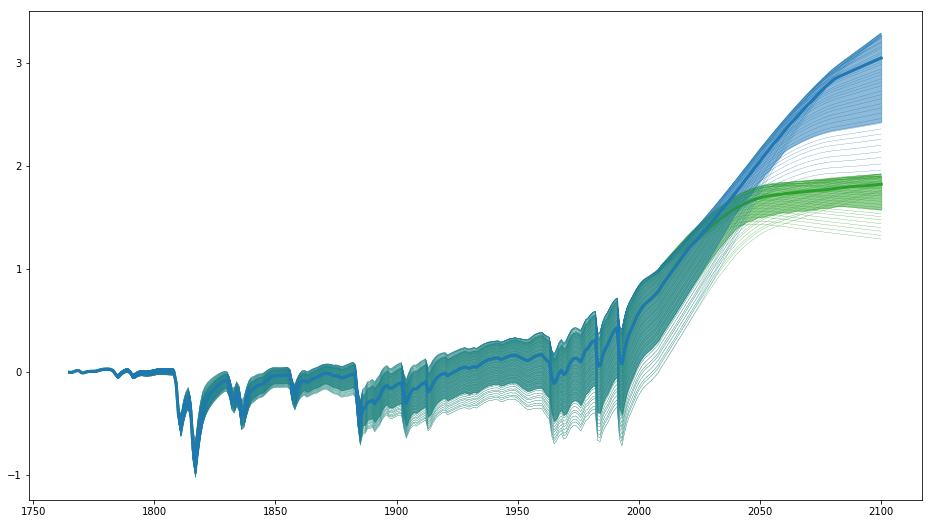

In [19]:
def _make_plot_ready(ts):
    ts.columns = ts.columns.map(lambda x: x.year)
    
    return ts

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

for scenario, colour in zip(res["scenario"].unique(), ("tab:green", "tab:blue")):
    temperatures = res.filter(variable="Surface Temperature", region="World", scenario=scenario)
    x_axis = _make_plot_ready(temperatures.timeseries()).columns

    ax.plot(
        x_axis,
        _make_plot_ready(temperatures.timeseries()).values.T,
        linewidth=0.25, 
        color=colour,
    )

    ax.plot(
        x_axis,
        _make_plot_ready(temperatures.process_over("run_id", "median")).values.T,
        color=colour,
        alpha=1,
        linewidth=3,
    )
    ax.fill_between(
        x_axis,
        _make_plot_ready(temperatures.process_over("run_id", operation="quantile", q=0.17)).values.squeeze(),
        _make_plot_ready(temperatures.process_over("run_id", operation="quantile", q=0.83)).values.squeeze(),
        color=colour,
        alpha=0.5,
        zorder=1.5,
    );